# Bargraph Reconstruction
This file does following tasks in same order.
- First the boundary box is found of bars using detectron2 and saved to json file
- That image is passed through paddle ocr to give xtics, ytics and Labels of Bargraph and saved to json file
- Those json  file information is used to reconstruct bargraph

These tasks installation and Import is done in each of their headings respectively



## Bargraph Boundary box inference

### Installation dont need if running locally


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 13.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15837 (delta 35), reused 14 (delta 14), pack-reused 15772 (from 2)
Receiving objects: 100% (15837/15837), 6.41 MiB | 3.84 MiB/s, done.
Resolving deltas: 100% (11533/11533), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your e

### Load the previsouly trained model

change the path in
config_yaml_path = "" #provide the path of config.yaml file
cfg.MODEL.WEIGHTS = "" #provide the path of model_final.pth file

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
import os
import torch

   # Load base configuration
cfg = get_cfg()


config_yaml_path = "/content/drive/MyDrive/Sangam Bar model/s/config.yaml" #provide the path of config.yaml file
cfg.merge_from_file(config_yaml_path)


cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Sangam Bar model/s/model_final.pth" #provide the path of model_final.pth file


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Adjust threshold as needed


if not torch.cuda.is_available():
    print("Warning: CUDA not available, using CPU instead.")
    cfg.MODEL.DEVICE = "cpu" #Force the model to use CPU


predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

### Bargraph inference and saved to json file

- first code section gives dominant colors
- second saves the json file and does it

These files will be changed for more accurate results later on

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


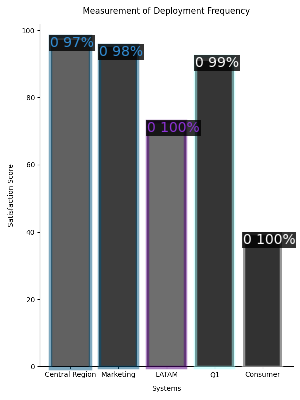

Results saved to /content/drive/MyDrive/bar/bar_2


In [ ]:
import cv2
import json
import csv
import numpy as np
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from sklearn.cluster import KMeans
from google.colab.patches import cv2_imshow

def get_dominant_color(image, k=1):
    """Extract dominant color using K-Means clustering."""
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))].astype(int)

def process_image(image_path, predictor, output_dir):
    """Process single image and save detection results."""
    # Load image
    im = cv2.imread(image_path)
    if im is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Run inference
    outputs = predictor(im)
    instances = outputs["instances"].to("cpu")

    if len(instances) == 0:
        print("No objects detected")
        return

    # Extract detection data
    detections = []
    metadata = MetadataCatalog.get("my_dataset_train")
    pred_boxes = instances.pred_boxes.tensor.numpy().astype(int)
    scores = instances.scores.numpy()
    pred_classes = instances.pred_classes.numpy()

    for i, (box, score, class_idx) in enumerate(zip(pred_boxes, scores, pred_classes)):
        x1, y1, x2, y2 = box
        roi = im[y1:y2, x1:x2]

        detections.append({
            "label": "bars",
            "confidence": float(score),
            "bbox": box.tolist(),
            "dominant_color": get_dominant_color(roi).tolist()
        })

    # Visualize results
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    cv2_imshow(v.draw_instance_predictions(instances).get_image()[:, :, ::-1])

    # Save results
    save_results(detections, image_path, output_dir)

def save_results(detections, image_path, output_dir):
    """Save detection results in multiple formats."""
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    os.makedirs(output_dir, exist_ok=True)

    # JSON format
    json_path = os.path.join(output_dir, f"{base_name}_detections.json")
    with open(json_path, "w") as f:
        json.dump({image_path: detections}, f, indent=4)

    # CSV format
    # csv_path = os.path.join(output_dir, f"{base_name}_detections.csv")
    # with open(csv_path, "w", newline="") as f:
    #     writer = csv.writer(f)
    #     writer.writerow(["image_path", "label", "confidence", "x1", "y1", "x2", "y2", "r", "g", "b"])
    #     for d in detections:
    #         x1, y1, x2, y2 = d["bbox"]
    #         r, g, b = d["dominant_color"]
    #         writer.writerow([image_path, d["label"], d["confidence"], x1, y1, x2, y2, r, g, b])

    # # TXT format
    # txt_path = os.path.join(output_dir, f"{base_name}_detections.txt")
    # with open(txt_path, "w") as f:
    #     f.write(f"Detection results for {image_path}:\n")
    #     for d in detections:
    #         f.write(f"Bar: {d['bbox']} | Color: {d['dominant_color']} | Confidence: {d['confidence']:.2f}\n")

    print(f"Results saved to {output_dir}")

# Usage example
image_path = "/content/drive/MyDrive/bar/bar_2/Bar_1.png"  # Single image path
output_directory = "/content/drive/MyDrive/bar/bar_2"    # Output directory
process_image(image_path, predictor, output_directory)

## PaddleOCR on Bargraph
- finds text files and saves to json to give xticks, yticks, categories,etc

### Installing paddle ocr
No need if running locally

In [ ]:
!pip install paddlepaddle
!pip install paddleocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 17.0 MB/s et

### Finding text file through paddleOCR
and saving it to make a json file

In [ ]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
import csv
import os
import urllib.request
import json  # Added for JSON support

img_path = '/content/drive/MyDrive/bar/bar_2/Bar_1.png'

def get_font():
    """Download a font file if it doesn't exist and return the path."""
    font_path = "DejaVuSans.ttf"

    # Only download if font doesn't exist
    if not os.path.exists(font_path):
        font_url = "https://github.com/PaddlePaddle/PaddleOCR/raw/release/2.6/doc/fonts/simfang.ttf"
        try:
            urllib.request.urlretrieve(font_url, font_path)
        except:
            # Fallback to a different font if the first one fails
            fallback_url = "https://github.com/opensourcedesign/fonts/raw/master/gnu-freefont_freesans/FreeSans.ttf"
            urllib.request.urlretrieve(fallback_url, font_path)

    return font_path

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Perform OCR
result = ocr.ocr(img_path, cls=True)

# Extract results from the first (and only) page
detections = result[0]

# Extract boxes, texts, and scores correctly
boxes = [detection[0] for detection in detections]
txts = [detection[1][0] for detection in detections]
scores = [detection[1][1] for detection in detections]

# Get font path
font_path = get_font()

# Draw OCR results on image
try:
    image = Image.open(img_path).convert('RGB')
    im_show = draw_ocr(image, boxes, txts, scores, font_path=font_path)
    im_show = Image.fromarray(im_show)
    im_show.save('result.jpg')
except Exception as e:
    print(f"Warning: Could not draw OCR results on image: {e}")

# Save structured results to CSV
# with open('ocr_results.csv', 'w', newline='', encoding='utf-8') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Box Coordinates', 'Text', 'Confidence'])
#     for box, text, score in zip(boxes, txts, scores):
#         writer.writerow([box, text, f"{score:.4f}"])

# Save structured results to JSON
with open('/content/drive/MyDrive/bar/bar_2/ocr_results.json', 'w', encoding='utf-8') as jsonfile:
    json_data = []
    for box, text, score in zip(boxes, txts, scores):
        json_data.append({
            "box": box,
            "text": text,
            "confidence": float(f"{score:.4f}")  # Format to 4 decimal places
        })
    json.dump(json_data, jsonfile, ensure_ascii=False, indent=4)

# Save human-readable text file
# with open('ocr_results.txt', 'w', encoding='utf-8') as f:
#     for i, (box, text, score) in enumerate(zip(boxes, txts, scores), 1):
#         f.write(f"Detection {i}:\n")
#         f.write(f"  Box Coordinates: {box}\n")
#         f.write(f"  Text: {text}\n")
#         f.write(f"  Confidence: {score:.4f}\n\n")

print("OCR processing completed. Check result.jpg, ocr_results.csv, ocr_results.json, and ocr_results.txt")

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:00<00:00, 4837.38it/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:01<00:00, 9841.21it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:00<00:00, 2933.54it/s]

[2025/02/28 11:14:51] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

[2025/02/28 11:14:54] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.5587387084960938
[2025/02/28 11:14:55] ppocr DEBUG: cls num  : 12, elapsed : 0.07737970352172852
[2025/02/28 11:14:56] ppocr DEBUG: rec_res num  : 12, elapsed : 1.4815058708190918
OCR processing completed. Check result.jpg, ocr_results.csv, ocr_results.json, and ocr_results.txt


### Optional cell
Delete saved files if redundent

In [ ]:
import os

def delete_ocr_files():
    files_to_delete = ['result.jpg', 'ocr_results.csv', 'ocr_results.txt','ocr_results.json']

    for file_name in files_to_delete:
        try:
            if os.path.exists(file_name):
                os.remove(file_name)
                print(f"Successfully deleted {file_name}")
            else:
                print(f"{file_name} does not exist")
        except Exception as e:
            print(f"Error deleting {file_name}: {e}")

if __name__ == "__main__":
    delete_ocr_files()

## Bargraph Reconsturction

Reconstruct the file and makes the bargraph json file
For Input provide two JSON file
- Bargraph json file
- PaddleOCR json file

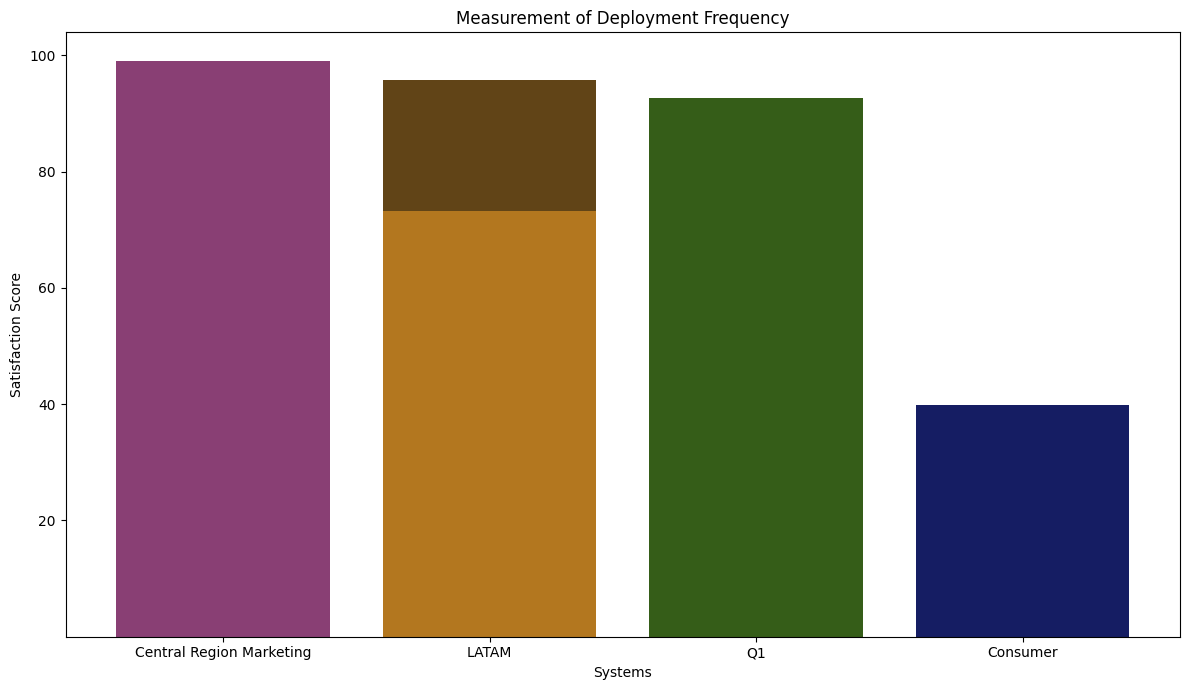

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re

class UniversalChartReconstructor:
    def __init__(self, ocr_path, detection_path):
        self.ocr_data = self.load_json(ocr_path)
        self.detections = self.load_detections(detection_path)
        self.img_width, self.img_height = self.detect_image_dimensions()

        # Initialize with defaults
        self.title = "Reconstructed Chart"
        self.x_label = "X-Axis"
        self.y_label = "Y-Axis"
        self.y_ticks = []             # List of dictionaries: {'value': float, 'position': float}
        self.x_categories = []        # X-axis tick labels
        self.x_category_positions = []  # For export
        self.bars = []
        self.y_scale = lambda h: h  # Will be set later

    @staticmethod
    def load_json(path):
        with open(path) as f:
            return json.load(f)

    def load_detections(self, path):
        data = self.load_json(path)
        if isinstance(data, dict):
            return list(data.values())[0]
        return data

    def detect_image_dimensions(self):
        try:
            all_x = [item['box'][2][0] for item in self.ocr_data] + [det['bbox'][2] for det in self.detections]
            all_y = [item['box'][2][1] for item in self.ocr_data] + [det['bbox'][3] for det in self.detections]
            return max(all_x), max(all_y)
        except Exception:
            return 1000, 800

    def process_ocr_elements(self):
        """
        Process each OCR element to extract:
          - x_center: horizontal center
          - y_center: vertical center
          - x1: x coordinate of the second point (for grouping y-ticks)
          - y3: y coordinate of the fourth point (for grouping x-ticks)
        Also add a flag 'used' (False by default) so we can mark recognized elements.
        """
        elements = []
        for item in self.ocr_data:
            text = item['text'].strip()
            box = item['box']
            x_center = (box[0][0] + box[1][0]) / 2
            y_center = (box[0][1] + box[2][1]) / 2
            x1 = box[1][0]
            y3 = box[3][1]
            elements.append({
                'text': text,
                'x_center': x_center,
                'y_center': y_center,
                'x1': x1,
                'y3': y3,
                'used': False
            })
        return elements

    def calculate_scaling(self):
        if not self.y_ticks:
            max_height = 0
            for det in self.detections:
                h = det['bbox'][3] - det['bbox'][1]
                if h > max_height:
                    max_height = h
            if max_height < 1:
                max_height = self.img_height

            def fallback_scale(h):
                return (h / max_height) * 10

            self.y_scale = fallback_scale

            self.y_ticks = []
            for value in range(0, 11, 2):
                h = (value / 10) * max_height
                pos = self.img_height - h
                self.y_ticks.append({'value': value, 'position': pos})
        else:
            y_values = [tick['value'] for tick in self.y_ticks]
            y_positions = [tick['position'] for tick in self.y_ticks]
            try:
                coeff = np.polyfit(y_positions, y_values, 1)
                self.y_scale = np.poly1d(coeff)
            except Exception:
                self.y_scale = lambda h: h

    def process_bars(self):
        for i, det in enumerate(self.detections):
            bbox = det['bbox']
            color = det.get('dominant_color', [i * 50 % 255 for i in range(3)])
            top_px = bbox[1]
            bottom_px = bbox[3]
            self.bars.append({
                'x_center': (bbox[0] + bbox[2]) / 2,
                'top_px': top_px,
                'bottom_px': bottom_px,
                'color': [c / 255 for c in color]
            })
        self.bars.sort(key=lambda x: x['x_center'])

    def map_bars_to_categories(self):
        bar_positions = [bar['x_center'] for bar in self.bars]
        if not self.x_categories:
            self.x_categories = [f"Item {i + 1}" for i in range(len(self.bars))]
            if bar_positions:
                min_pos = min(bar_positions)
                max_pos = max(bar_positions)
            else:
                min_pos = 0
                max_pos = self.img_width
            self.x_category_positions = np.linspace(min_pos, max_pos, len(self.x_categories))
        else:
            if bar_positions:
                min_pos = min(bar_positions)
                max_pos = max(bar_positions)
            else:
                min_pos = 0
                max_pos = self.img_width
            self.x_category_positions = np.linspace(min_pos, max_pos, len(self.x_categories))

        for bar in self.bars:
            idx = np.argmin([abs(bar['x_center'] - pos) for pos in self.x_category_positions])
            bar['category'] = self.x_categories[idx]

    def cluster_labels(self, labels, threshold):
        if not labels:
            return []
        clusters = []
        current_cluster = [labels[0]]
        for label in labels[1:]:
            if label[1] - current_cluster[-1][1] < threshold:
                current_cluster.append(label)
            else:
                clusters.append(current_cluster)
                current_cluster = [label]
        if current_cluster:
            clusters.append(current_cluster)
        return [' '.join([item[0] for item in cluster]) for cluster in clusters]

    def extract_labels(self, ocr_elements):
        # --- X-axis label & ticks ---
        x_axis_candidates = [elem for elem in ocr_elements if elem['y_center'] > self.img_height * 0.75]
        if x_axis_candidates:
            x_axis_candidates.sort(key=lambda e: e['y_center'], reverse=True)
            self.x_label = x_axis_candidates[0]['text']
            x_axis_candidates[0]['used'] = True  # mark as used for x-axis label
            tick_candidates = x_axis_candidates[1:]
            if tick_candidates:
                median_y3 = np.median([elem['y3'] for elem in tick_candidates])
                delta = 10
                filtered_x_ticks = [elem for elem in tick_candidates if abs(elem['y3'] - median_y3) <= delta]
                filtered_x_ticks.sort(key=lambda e: e['x_center'])
                self.x_categories = [elem['text'] for elem in filtered_x_ticks]
                for elem in filtered_x_ticks:
                    elem['used'] = True  # mark these as used for x-ticks
            else:
                self.x_categories = []
        else:
            x_tick_candidates = [
                elem for elem in ocr_elements
                if (not re.match(r"^\d+(\.\d+)?$", elem['text'])) and elem['y_center'] > self.img_height * 0.75
            ]
            if x_tick_candidates:
                median_y3 = np.median([elem['y3'] for elem in x_tick_candidates])
                delta = 10
                filtered_x_ticks = [elem for elem in x_tick_candidates if abs(elem['y3'] - median_y3) <= delta]
                filtered_x_ticks.sort(key=lambda e: e['x_center'])
                self.x_categories = [elem['text'] for elem in filtered_x_ticks]
                self.x_label = "Categories"
                for elem in filtered_x_ticks:
                    elem['used'] = True

        # --- Y-axis ticks ---
        y_tick_candidates = [elem for elem in ocr_elements if re.match(r"^\d+(\.\d+)?$", elem['text'])]
        if y_tick_candidates:
            median_x1 = np.median([elem['x1'] for elem in y_tick_candidates])
            delta = 10
            filtered_y_ticks = [elem for elem in y_tick_candidates if abs(elem['x1'] - median_x1) <= delta]
            filtered_y_ticks.sort(key=lambda e: e['y_center'], reverse=True)
            self.y_ticks = [{'value': float(elem['text']), 'position': elem['y_center']}
                            for elem in filtered_y_ticks]
            for elem in filtered_y_ticks:
                elem['used'] = True

        # --- Y-axis label ---
        y_axis_candidates = [
            elem for elem in ocr_elements
            if elem['x_center'] < self.img_width * 0.1 and
               (self.img_height * 0.2 < elem['y_center'] < self.img_height * 0.8) and
               not re.match(r"^\d+(\.\d+)?$", elem['text'])
        ]
        if y_axis_candidates:
            y_axis_candidates.sort(key=lambda e: e['y_center'])
            self.y_label = ' '.join([e['text'] for e in y_axis_candidates])
            for elem in y_axis_candidates:
                elem['used'] = True
        else:
            if not self.y_label:
                self.y_label = "Values"

        # --- Title Extraction via Spatial Consistency ---
        # Now that we have assigned other roles, take any remaining text as title candidates.
        remaining = [elem for elem in ocr_elements if not elem['used']]
        # For spatial consistency, we filter for elements in the upper half and near the horizontal center.
        title_candidates = [elem for elem in remaining if elem['y_center'] < self.img_height * 0.5]
        if title_candidates:
            # Optionally, one could cluster if there are multiple candidates.
            # Here, we simply sort them by vertical position and join their text.
            title_candidates.sort(key=lambda e: e['y_center'])
            self.title = " ".join([elem['text'] for elem in title_candidates])
        else:
            # Fallback if no candidate remains
            self.title = "Reconstructed Chart"

    def reconstruct(self):
        try:
            ocr_elements = self.process_ocr_elements()
            self.extract_labels(ocr_elements)
            self.process_bars()
            self.calculate_scaling()

            # Compute bar values using the scaled top and bottom pixel coordinates.
            for bar in self.bars:
                top_val = self.y_scale(bar['top_px'])
                bottom_val = self.y_scale(bar['bottom_px'])
                bar_height = bottom_val - top_val
                if bar_height < 0:
                    bar_height = -bar_height
                bar['value'] = bar_height

            self.map_bars_to_categories()
            self.plot_chart()
        except Exception as e:
            print(f"Reconstruction error: {str(e)}")
            self.plot_chart()

    def plot_chart(self):
        plt.figure(figsize=(12, 7))
        categories = [bar.get('category', f"Bar {i + 1}") for i, bar in enumerate(self.bars)]
        values = [bar.get('value', 0) for bar in self.bars]
        colors = [bar['color'] for bar in self.bars]

        plt.bar(categories, values, color=colors)
        plt.title(self.title)
        plt.xlabel(self.x_label)
        plt.ylabel(self.y_label)

        if self.y_ticks:
            unique_values = sorted({tick['value'] for tick in self.y_ticks})
            plt.yticks(unique_values)

        plt.xticks(rotation=0, ha='center')
        plt.tight_layout()
        plt.show()

    def export_json(self, output_path):
        chart_data = {
            "title": self.title,
            "x_label": self.x_label,
            "y_label": self.y_label,
            "x_ticks": [
                {"label": label, "position": float(pos)}
                for label, pos in zip(self.x_categories, self.x_category_positions)
            ],
            "y_ticks": [
                {"value": tick['value'], "position": float(tick['position'])}
                for tick in self.y_ticks
            ],
            "bars": [
                {
                    "category": bar.get('category', ''),
                    "color": [round(c, 4) for c in bar['color']],
                    "value": float(bar.get('value', 0)),
                    "top_px": float(bar['top_px']),
                    "bottom_px": float(bar['bottom_px']),
                    "x_center": float(bar['x_center'])
                }
                for bar in self.bars
            ]
        }
        with open(output_path, 'w') as f:
            json.dump(chart_data, f, indent=2)

if __name__ == "__main__":
    reconstructor = UniversalChartReconstructor(
        ocr_path="/content/drive/MyDrive/bar/bar_2/ocr_results.json",
        detection_path="/content/drive/MyDrive/bar/bar_2/Bar_1_detections.json"
    )
    reconstructor.reconstruct()
    reconstructor.export_json("/content/drive/MyDrive/bar/bar_2/chart_data.json")
